In [1]:
import pandas as pd
import requests as rq

url = 'https://servicodados.ibge.gov.br/api/v1/localidades/estados/pa/municipios'
   
res = rq.request("GET", url)

#Creates a data frame with the Municipalities column.
if res.status_code == 200:
    df_munic = pd.DataFrame({'id': [], 'localidade': []})
    
    for id, munic in enumerate(res.json()):
        df_munic.loc[id] = [str(munic['id'])[:6], munic['nome']]


        90201: Delegacia especializada no Atendimento à Mulher
    90335: Executa programas e ações para grupos específicos - Mulheres
        90358: Enfrentamento à Violência contra a Mulher
    90626: Direitos ou política para mulheres
    90640: Políticas ou programas na área de direitos humanos - Proteção de mulheres vítimas de violência doméstica 
        90272: Ações Socioeducativas - Violência doméstica e de gênero
    90397: Constituição de centros de referência e atendimento em direitos humanos

In [2]:
indicators = ['90201','90335','90358','90626','90640', '90272', '90397']

url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/1/periodos/2019/indicadores/"

# Adding indicators to the end of the url
for i, ind in enumerate(indicators):
    if i != (len(indicators)-1):
        url += ind + '|'
    else:
        url += ind + '/'
        
# Function to Formatting final url
def urlResultadosPorMunicipos(url, df):
    url += 'resultados/'    

    for i, row in df_munic.iterrows():
        if i != (len(df)-1):
            url += row.id + '|'
        else:
            url += row.id + '/'
    
    return url


url = urlResultadosPorMunicipos(url, df_munic)

# return json results
res = rq.request("GET", url)


In [3]:
if res.status_code == 200:
    
    #Scrolls through the json and inserts the data into the main dataframe for each selected indicator.
    for indicador in res.json():
        df_temp = pd.DataFrame(indicador['res'])
        df_temp = df_temp[['localidade', 'res']]
        df_temp.rename(columns = {'localidade':'id', 'res': indicador['id']}, inplace = True)
        
        #It replaces the words "Yes" and "No" with binary information 1 and 0.
        df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1 if x['2019']  == 'Sim' else 0)
        df_munic = pd.merge(df_munic, df_temp, on="id")

In [4]:
df_munic

,id,localidade,90201,90272,90335,90358,90397,90626,90640
0,150010,Abaetetuba,1,0,1,0,0,1,1
1,150013,Abel Figueiredo,0,0,0,0,0,0,1
2,150020,Acará,0,0,1,0,0,1,1
3,150030,Afuá,0,0,1,0,0,1,1
4,150034,Água Azul do Norte,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
139,150815,Uruará,0,0,1,0,0,0,0
140,150820,Vigia,0,0,0,0,0,0,0
141,150830,Viseu,0,0,1,0,0,0,0
142,150835,Vitória do Xingu,0,0,1,1,0,1,1


In [5]:
df_munic['Rede_de_Protecao_assistencia'] = df_munic[90201] + df_munic[90272] + df_munic[90335] + df_munic[90358] + df_munic[90397] + df_munic[90626] + df_munic[90640]
df_munic = df_munic[['id', 'localidade', 'Rede_de_Protecao_assistencia']]

In [6]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/37/periodos/2010/indicadores/30255/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)

# correction of missing values
x = res.json()
x[0]['res'][73]['res']['2010'] = '0'
x

df_temp = pd.json_normalize(x[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2010': 'IDH'}, inplace=True)
df_temp = df_temp[['id', 'IDH']]
df_munic = pd.merge(df_munic, df_temp, on='id')

In [7]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/38/periodos/2019/indicadores/47001/"

url = urlResultadosPorMunicipos(url, df_munic)   
res = rq.request("GET", url)
df_temp = pd.json_normalize(res.json()[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2019': 'PIB'}, inplace=True)
df_temp = df_temp[['id', 'PIB']]
df_munic = pd.merge(df_munic, df_temp, on='id')

In [8]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/36/periodos/2003/indicadores/30252/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)
# correction of missing values
x = res.json()
x[0]['res'].append({'localidade': '150475', 'res': {'2003': '0.00'}, 'notas': {'2003': None}})

df_temp = pd.json_normalize(x[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2003': 'GINI'}, inplace=True)
df_temp = df_temp[['id', 'GINI']]
df_munic = pd.merge(df_munic, df_temp, on='id', how='left')

In [9]:
df_munic['Rede_de_Protecao_assistencia'] = pd.to_numeric(df_munic['Rede_de_Protecao_assistencia'])
df_munic['IDH'] = pd.to_numeric(df_munic['IDH'])
df_munic['PIB'] = pd.to_numeric(df_munic['PIB'])
df_munic['GINI'] = pd.to_numeric(df_munic['GINI'])

In [10]:
df_munic

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI
0,150010,Abaetetuba,4,0.628,9458.72,0.40
1,150013,Abel Figueiredo,1,0.622,11420.76,0.37
2,150020,Acará,3,0.506,13582.97,0.36
3,150030,Afuá,3,0.489,9405.70,0.39
4,150034,Água Azul do Norte,1,0.564,15819.85,0.37
...,...,...,...,...,...,...
139,150815,Uruará,1,0.589,13401.03,0.38
140,150820,Vigia,0,0.617,7216.02,0.36
141,150830,Viseu,1,0.515,7952.36,0.37
142,150835,Vitória do Xingu,4,0.596,270414.24,0.38


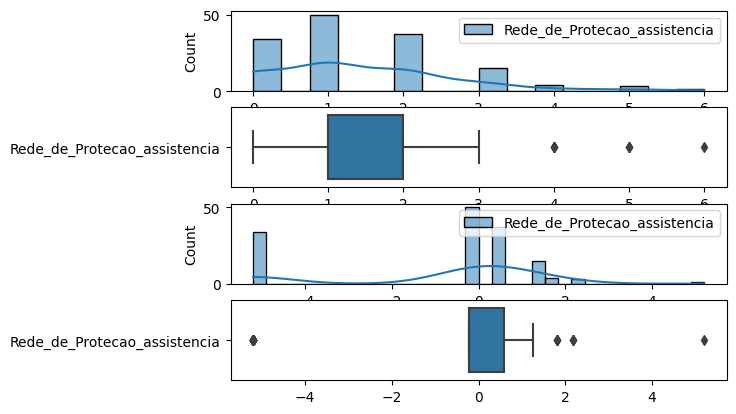

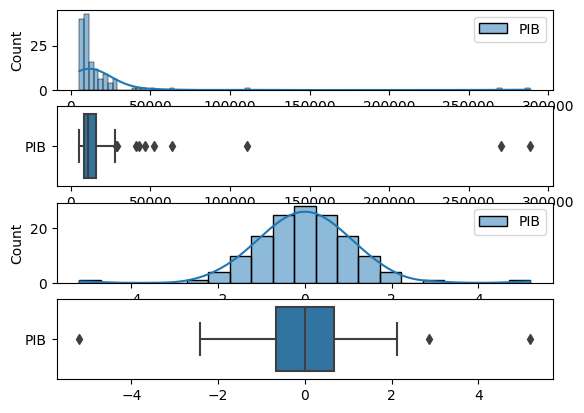

In [11]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from scipy import stats

rng = np.random.RandomState(10)

scaler1 = preprocessing.MinMaxScaler(feature_range=(1,2))
scaler2 = preprocessing.PowerTransformer(method='yeo-johnson')
scaler3 = preprocessing.PowerTransformer(method='box-cox')
scaler4 = preprocessing.QuantileTransformer(n_quantiles=100, output_distribution="normal", random_state=12, copy=True)
scaler5 = preprocessing.MaxAbsScaler()



pipeline = Pipeline(steps=[('s', scaler1),('p', scaler4)])

# transform training data & save lambda value


d1 = scaler4.fit_transform(df_munic.iloc[:,2:3])
d2 = scaler1.fit_transform(df_munic.iloc[:,3:4])
d3 = scaler4.fit_transform(df_munic.iloc[:,4:5])
d4 = scaler1.fit_transform(df_munic.iloc[:,5:6])


ds = [d1, d2, d3, d4]

scaled_df = pd.DataFrame()
cont = 2
for i in ds:

    s_df = pd.DataFrame(i, columns=df_munic.iloc[:,cont:cont+1].columns)
    scaled_df = pd.concat([scaled_df, s_df], axis=1)
    cont += 1

scaled_df = pd.concat([df_munic.iloc[:,:2], scaled_df], axis=1)
#scaled_df

import matplotlib.pyplot as plt
import seaborn as sns

splot = scaled_df.iloc[:,2:3]
dplot = df_munic.iloc[:,2:3]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
sns.histplot(splot, kde=True, ax=ax3)
sns.boxplot(splot, orient="h", ax=ax4)
#plt.xlim(-1, 1)
plt.show()

splot = scaled_df.iloc[:,4:5]
dplot = df_munic.iloc[:,4:5]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
sns.histplot(splot, kde=True, ax=ax3)
sns.boxplot(splot, orient="h", ax=ax4)
#plt.xlim(-1, 1)
plt.show()



In [12]:
scaled_df.describe()

,Rede_de_Protecao_assistencia,IDH,PIB,GINI
count,144.000000,144.000000,144.000000,144.000000
mean,-0.898426,1.774138,0.002725,1.761196
std,2.502131,0.099055,1.148576,0.081778
min,-5.199338,1.000000,-5.199338,1.000000
25%,-0.229884,1.732909,-0.672726,1.734694
50%,-0.229884,1.780831,-0.001450,1.775510
75%,0.574460,1.822386,0.674525,1.795918
max,5.199338,2.000000,5.199338,2.000000


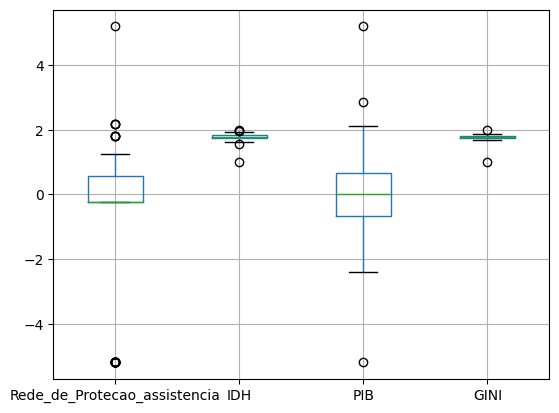

array([[-2.29884118e-01,  1.60723861e+00, -2.41289176e+00,
         1.67346939e+00],
       [-2.29884118e-01,  1.73290885e+00, -6.72725882e-01,
         1.73469388e+00],
       [-2.29884118e-01,  1.78083110e+00, -1.44983131e-03,
         1.77551020e+00],
       [ 5.74459993e-01,  1.82238606e+00,  6.74524926e-01,
         1.79591837e+00],
       [ 1.24775386e+00,  1.92627346e+00,  2.12042579e+00,
         1.87755102e+00]])

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def create_boxplot(dataset):

    Q3 = np.quantile(dataset, 0.75)
    Q1 = np.quantile(dataset, 0.25)
    MEDIAN = np.quantile(dataset, 0.50)
    IQR = Q3 - Q1

    lower_range = Q1 - 0.15 * IQR
    upper_range = Q3 + 0.15 * IQR

    while lower_range < 0:
        dst = dataset[dataset[dataset.columns[0]] > Q1]
        
        Q3 = np.quantile(dst, 0.75)
        Q1 = np.quantile(dst, 0.25)
        MEDIAN = np.quantile(dst, 0.50)
        IQR = Q3 - Q1
    
        lower_range = Q1 - 0.15 * IQR
        upper_range = Q3 + 0.15 * IQR

        dataset = dst
        
    print(f"Q3 = {Q3}")
    print(f"Q1 = {Q1}")
    print(f"IQR = {IQR}")
    print(f"Median = {MEDIAN}")
    print(f"Lower_Range = {lower_range}")
    print(f"Upper_Range = {upper_range}")
    
    
def print_limits(dataset) -> np.array:

    res = np.zeros((5, 4))

    #boxplot create
    _, bp = pd.DataFrame.boxplot(dataset, return_type='both')
    caps = [cap.get_ydata() for cap in bp["caps"]] # limites inferior e superior
    outliers = [flier.get_ydata() for flier in bp["fliers"]]  # Desconsiderar
    boxes = [box.get_ydata() for box in bp["boxes"]] # Q1 e Q3
    medians = [median.get_ydata() for median in bp["medians"]] # Mediana
    whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]] # Q1 Q3 LimSup LimInf
    plt.show()

    cont = 0
    for c in range(0, len(whiskers), 2):
        lower_range = whiskers[c][1]

        Q1 = whiskers[c][0]
        M = medians[cont][0]
        Q3 = whiskers[c+1][0]

        upper_range = whiskers[c+1][1]

        

        res[0][cont] = lower_range
        res[1][cont] = Q1
        res[2][cont] = M
        res[3][cont] = Q3
        res[4][cont] = upper_range

        cont += 1
    
    
    return res
         

print_limits(scaled_df.iloc[:,2:6])

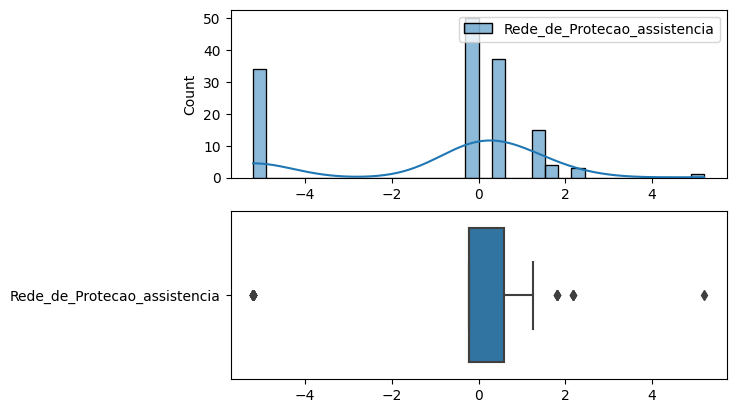

In [14]:

dplot = scaled_df.iloc[:,2:3]

fig, (ax1, ax2) = plt.subplots(2)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
#plt.xlim(-1, 1)
plt.show()

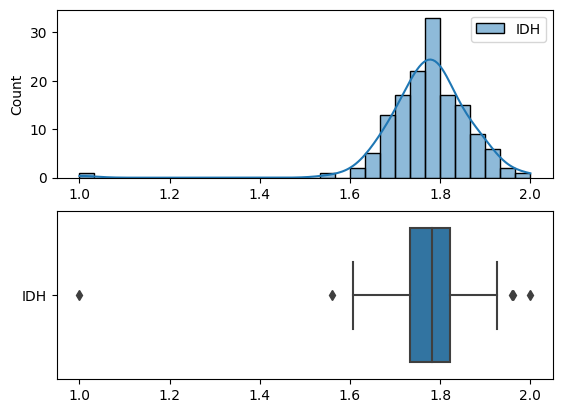

In [15]:
dplot = scaled_df.iloc[:,3:4]

fig, (ax1, ax2) = plt.subplots(2)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
plt.show()

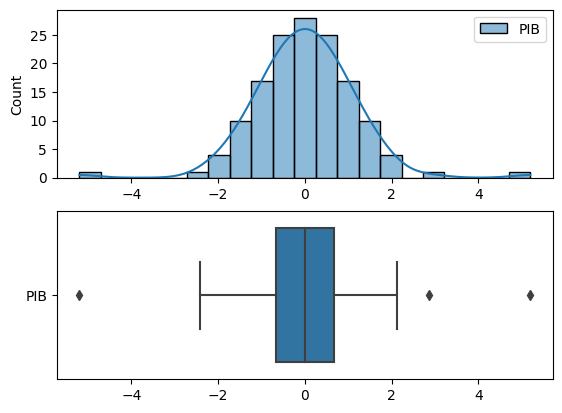

In [16]:
dplot = scaled_df.iloc[:,4:5]

fig, (ax1, ax2) = plt.subplots(2)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
plt.show()

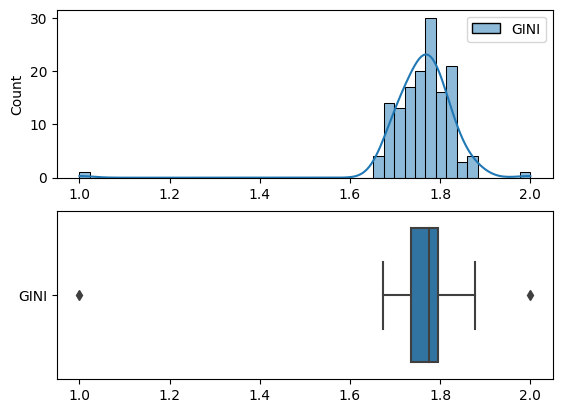

In [17]:
dplot = scaled_df.iloc[:,5:6]

fig, (ax1, ax2) = plt.subplots(2)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
plt.show()

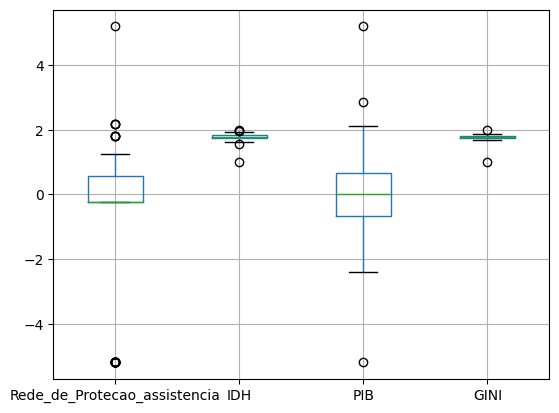

array([[-2.29884118e-01,  1.60723861e+00, -2.41289176e+00,
         1.67346939e+00],
       [-2.29884118e-01,  1.73290885e+00, -6.72725882e-01,
         1.73469388e+00],
       [-2.29884118e-01,  1.78083110e+00, -1.44983131e-03,
         1.77551020e+00],
       [ 5.74459993e-01,  1.82238606e+00,  6.74524926e-01,
         1.79591837e+00],
       [ 1.24775386e+00,  1.92627346e+00,  2.12042579e+00,
         1.87755102e+00]])

In [18]:
     #IP       #IDH      #PIB      #GINI
Q = [0.05,      0.05,       0.05,      0.05]
P = [0.08,      0.08,       0.08,      0.08]
V = [2.0,      2.0,       2.0,      2.0]
W = [0.5,      0.5,       0.5,      0.5]

B = print_limits(scaled_df.iloc[:,2:6]).tolist()
#B = print_limits(df_munic.iloc[:,2:6]).tolist()

np.array(B)

In [19]:
#df_munic.query('Rede_de_Protecao_assistencia < 0.15')
scaled_df.query('Rede_de_Protecao_assistencia < -1.4520')

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI
5,150040,Alenquer,-5.199338,1.756032,-0.114185,1.795918
6,150050,Almeirim,-5.199338,1.860590,0.647535,2.000000
7,150060,Altamira,-5.199338,1.891421,1.190582,1.816327
10,150085,Anapu,-5.199338,1.734584,0.541616,1.816327
12,150095,Aurora do Pará,-5.199338,1.695710,-1.577242,1.734694
16,150125,Bannach,-5.199338,1.796247,1.219070,1.775510
19,150145,Belterra,-5.199338,1.788204,-0.334569,1.693878
25,150175,Brejo Grande do Araguaia,-5.199338,1.792225,0.062982,1.775510
29,150195,Cachoeira do Piriá,-5.199338,1.634048,-5.199338,1.714286
42,150280,Curralinho,-5.199338,1.672922,-1.163250,1.795918


In [20]:
T = scaled_df.iloc[:, 2:].values

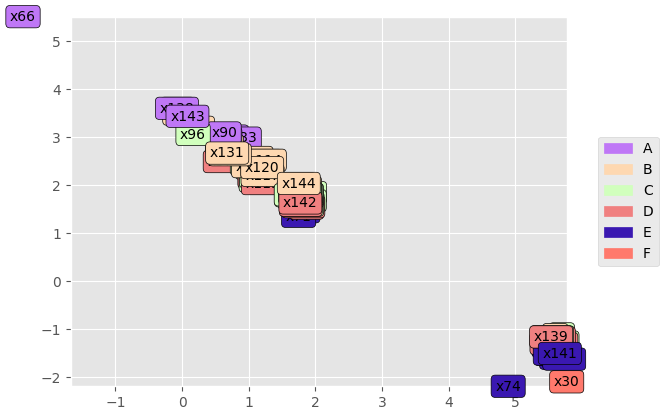

In [21]:
from pyDecision.algorithm import electre_tri_b

classification = electre_tri_b(T, W , Q , P , V , B, cut_level = 0.6, verbose = False, rule = 'oc', graph = True)

In [22]:
classification.count(0)

8

In [23]:
scaled_df['CLASS'] = classification

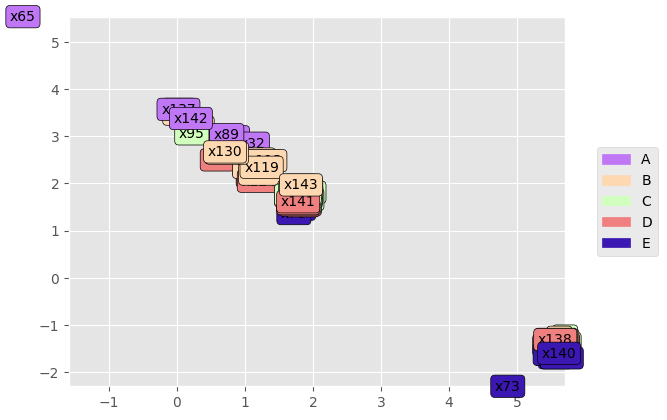

In [24]:
df__ = scaled_df.query('CLASS != 5')

df_ = df__.iloc[:, 2:6]


c = electre_tri_b(np.array(df_), W , Q , P , V , B, cut_level = 0.6, verbose = False, rule = 'oc', graph = True)


In [25]:
scaled_df = scaled_df.rename(index=lambda s: 'x' + str(s + 1))

In [26]:
scaled_df.query('CLASS == 0')

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI,CLASS
x18,150130,Barcarena,2.166107,1.887399,1.729758,1.836735,0
x19,150140,Belém,1.247754,2.000000,1.057380,1.877551,0
x33,150215,Canaã dos Carajás,0.574460,1.902145,5.199338,1.734694,0
x66,150420,Marabá,5.199338,1.895442,1.687439,1.836735,0
x89,150550,Paragominas,1.247754,1.864611,1.474522,1.836735,0
x90,150553,Parauapebas,1.247754,1.958445,2.120426,1.795918,0
x138,150810,Tucuruí,2.166107,1.892761,1.796290,1.816327,0
x143,150835,Vitória do Xingu,1.807354,1.798928,2.868427,1.775510,0


In [27]:
import geopandas as gpd

gdf_munic = gpd.read_file('json/munics.geojson')

for value in gdf_munic['id']:
    gdf_munic['id'].replace(to_replace=value, value=value[:6], regex=True,inplace=True)


df_teste = pd.merge(scaled_df, gdf_munic, on='id', how='left')

df_teste = df_teste[['id', 'localidade', 'geometry']]

df_teste['classe'] = classification

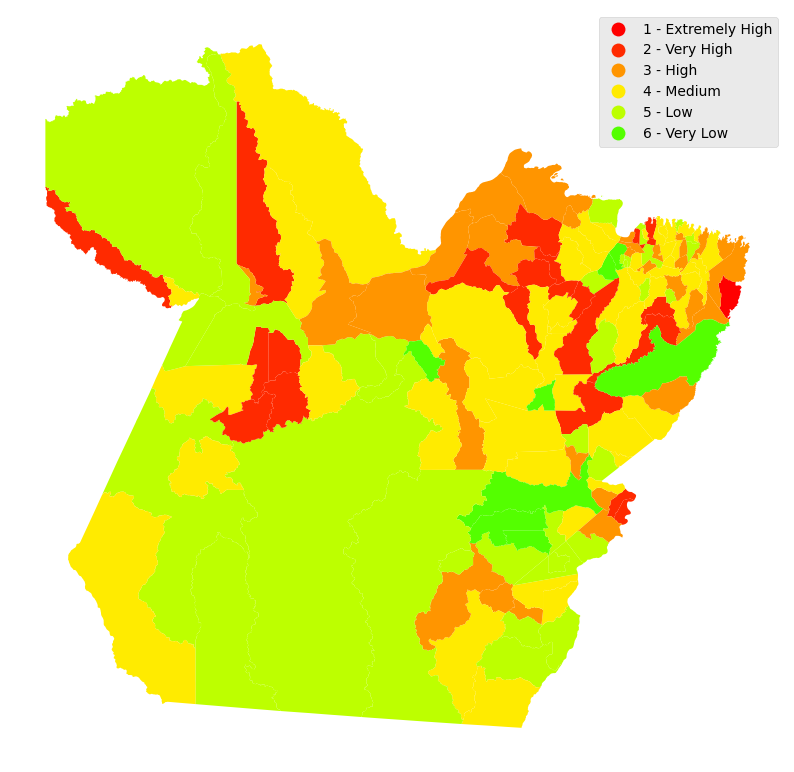

In [28]:
clusdict={5: '1 - Extremely High', 4: '2 - Very High', 3: '3 - High', 2: '4 - Medium', 1: '5 - Low', 0: '6 - Very Low' }
df_teste['legenda'] = df_teste['classe'].map(clusdict)
df_teste['classe'] = classification

gpd_teste = gpd.GeoDataFrame(df_teste)

ax = gpd_teste.plot(column='legenda', categorical=True, legend=True, legend_kwds={'loc': 'upper right'}, figsize=(10,10), cmap='prism')

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

replace_legend_items(ax.get_legend(), clusdict)

ax.set_axis_off()

In [29]:
denuncias = pd.read_json('json/casos_violencia_por_municipio.json')
denuncias = denuncias.rename(index=lambda s: 'x' + str(s + 1))

scaled_df['denuncias'] = denuncias['casos']

In [30]:
scaled_df

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI,CLASS,denuncias
x1,150010,Abaetetuba,1.807354,1.841823,-0.292245,1.816327,1,77
x2,150013,Abel Figueiredo,-0.229884,1.833780,0.213061,1.755102,2,0
x3,150020,Acará,1.247754,1.678284,0.404108,1.734694,2,11
x4,150030,Afuá,1.247754,1.655496,-0.303275,1.795918,3,1
x5,150034,Água Azul do Norte,-0.229884,1.756032,0.632117,1.755102,1,4
...,...,...,...,...,...,...,...,...
x140,150815,Uruará,-0.229884,1.789544,0.374977,1.775510,2,2
x141,150820,Vigia,-5.199338,1.827078,-1.353800,1.734694,4,10
x142,150830,Viseu,-0.229884,1.690349,-0.785002,1.755102,3,4
x143,150835,Vitória do Xingu,1.807354,1.798928,2.868427,1.775510,0,6


[Text(0.5, 0, 'Support and Protection Index (IAP)'),
 Text(0, 0.5, 'Denunciations')]

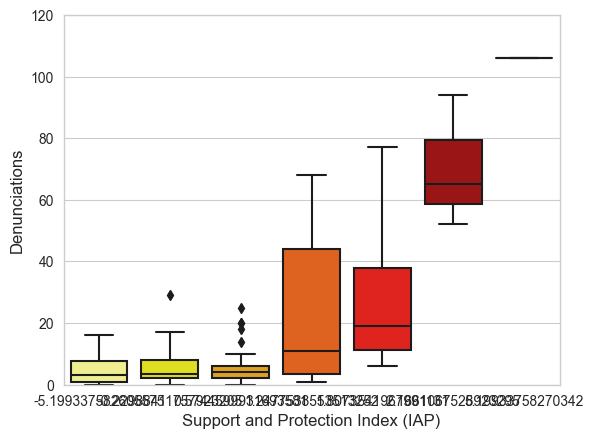

In [31]:
data = scaled_df

sns.set_style("whitegrid")
 
# depict visualization
gfg = sns.boxplot(x="Rede_de_Protecao_assistencia", y="denuncias", data=data, palette='hot_r')

gfg.set_ylim(0, 120)
gfg.set(xlabel ="Support and Protection Index (IAP)", ylabel = "Denunciations")

